In [1]:
## run once then restart kernel, then run again
## to prevent 'no algorithm worked!' error
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
##

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import cv2

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [3]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

In [4]:
# # @title Choose the model to use, then evaluate the cell.
# MODELS = {'centernet_with_keypoints': 'centernet_hg104_512x512_kpts_coco17_tpu-32', 'centernet_without_keypoints': 'centernet_hg104_512x512_coco17_tpu-8'}

# model_display_name = 'centernet_without_keypoints' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
# model_name = MODELS[model_display_name]

# # Download the checkpoint and put it into models/research/object_detection/test_data/

# if model_display_name == 'centernet_with_keypoints':
#   !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
#   !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
#   !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
# else:
#   !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
#   !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
#   !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

## OD: efficientdet_d7_coco17_tpu

In [4]:
import os
# centernet_mobilenet version
# model_name = 'centernet_mobilenetv2_fpn_od'
model_name = 'efficientdet_d7_coco17_tpu-32'
pipeline_config = 'tensorflow/models/research/object_detection/test_data/efficientdet_d7_coco17_tpu-32/pipeline.config'
model_dir = 'tensorflow/models/research/object_detection/test_data/efficientdet_d7_coco17_tpu-32/checkpoint'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [5]:
# label_map_path = 'tensorflow/models/research/object_detection/test_data/efficientdet_d7_coco17_tpu-32/label_map.txt'
label_map_path = 'tensorflow/models/research/object_detection/data/mscoco_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [6]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

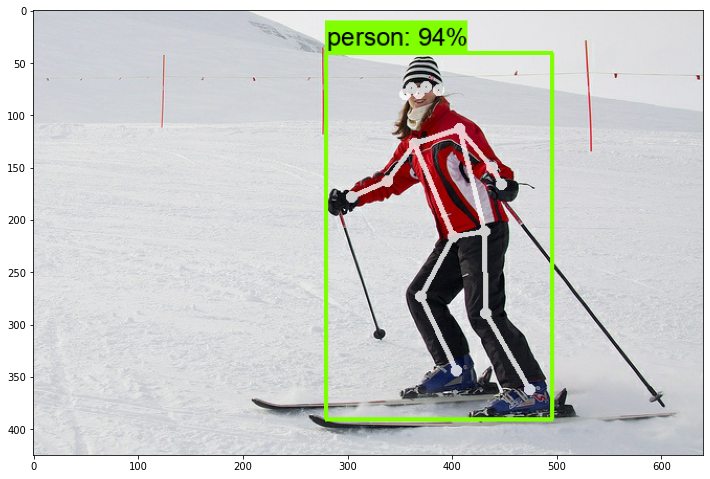

In [11]:
image_path = '/media/jose/Toshiba SSD1/Aictive/evopose2d/evopose2d/ski.jpg'
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

## OD: ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8 or ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8

In [4]:
import os
import json
# centernet_mobilenet version
# model_name = 'centernet_mobilenetv2_fpn_od'
model_name = 'centernet_hg104_512x512_coco17_tpu-8'
pipeline_config = 'tensorflow/models/research/object_detection/test_data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'
model_dir = 'tensorflow/models/research/object_detection/test_data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)
    
    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [5]:
# label_map_path = 'tensorflow/models/research/object_detection/test_data/efficientdet_d7_coco17_tpu-32/label_map.txt'
label_map_path = 'tensorflow/models/research/object_detection/data/mscoco_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

## Defining EvoPose2D function

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
[280.79, 44.73, 218.7, 346.68]


array([[[210, 205, 202],
        [211, 206, 203],
        [211, 206, 203],
        ...,
        [220, 218, 218],
        [218, 218, 218],
        [218, 218, 218]],

       [[210, 205, 202],
        [211, 206, 203],
        [211, 206, 203],
        ...,
        [220, 218, 218],
        [218, 218, 218],
        [218, 218, 218]],

       [[213, 208, 205],
        [213, 208, 205],
        [213, 208, 205],
        ...,
        [221, 219, 219],
        [218, 218, 218],
        [218, 218, 218]],

       ...,

       [[226, 226, 226],
        [220, 221, 219],
        [214, 212, 211],
        ...,
        [203, 199, 194],
        [205, 200, 197],
        [204, 201, 197]],

       [[219, 219, 219],
        [220, 218, 218],
        [220, 218, 218],
        ...,
        [197, 193, 188],
        [197, 193, 188],
        [199, 195, 190]],

       [[221, 216, 217],
        [217, 213, 212],
        [224, 220, 219],
        ...,
        [200, 190, 183],
        [201, 192, 188],
        [198, 194, 189]]

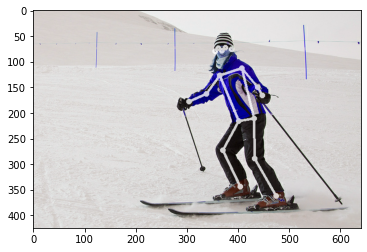

In [6]:
# conectar a evopose2d

import argparse
from pycocotools.coco import COCO
import os.path as osp
import tensorflow as tf
from dataset.dataloader import preprocess
from dataset.coco import cn as cfg
import numpy as np
from validate import get_preds
import cv2

KP_PAIRS = [[5, 6], [6, 12], [12, 11], [11, 5],
            [5, 7], [7, 9], [11, 13], [13, 15],
            [6, 8], [8, 10], [12, 14], [14, 16]]


# python3 demo.py -c evopose2d_M_f32.yaml -p '/media/jose/Toshiba SSD1/Aictive/evopose2d/evopose2d/coco'
CONFIG = 'evopose2d_M_f32.yaml'
COCO_PATH = '/media/jose/Toshiba SSD1/Aictive/evopose2d/evopose2d/coco'
IMG_ID = 785
ALPHA = 0.8

# parser = argparse.ArgumentParser()
# parser.add_argument('-c', '--cfg', default='evopose2d_M_f32.yaml')
# parser.add_argument('-p', '--coco-path', required=True,
#                     help='Path to folder containing COCO images and annotation directories.')
# parser.add_argument('-i', '--img-id', type=int, default=785)
# parser.add_argument('--alpha', type=float, default=0.8)
# args = parser.parse_args()

# load the config .yaml file
cfg.merge_from_file('configs/' + CONFIG)

# load the trained model
model = tf.keras.models.load_model('models/{}.h5'.format(CONFIG.split('.yaml')[0]))
cfg.DATASET.OUTPUT_SHAPE = model.output_shape[1:]

# load the dataset annotations
coco = COCO(osp.join(COCO_PATH, 'annotations', 'person_keypoints_val2017.json'))
# load image
img_data = coco.loadImgs([785])[0]

annotation = coco.loadAnns(coco.getAnnIds([785]))[0]
bbox = annotation['bbox']
kp = np.array(annotation['keypoints']).reshape(-1, 3)  # not used

# get test image
img_bytes = open(osp.join(COCO_PATH, 'images', 'val2017', img_data['file_name']), 'rb').read()
img = tf.image.decode_jpeg(img_bytes, channels=3)
# print(img.numpy())

# preprocess: receives bbox points in pixels by [xmin, ymin, width, height]
print(bbox)

def evopose2d_predict(img, bbox):
    img = tf.image.convert_image_dtype(img, dtype=tf.uint8, saturate=False)
    _, norm_img, _, M, _ = preprocess(0, img, bbox, kp, 0., cfg.DATASET, split='val', predict_kp=True)
    M = np.expand_dims(np.array(M), axis=0)

    # generate heatmap predictions
    hms = model.predict(tf.expand_dims(norm_img, 0))

    # get keypoint predictions from heatmaps
    preds = get_preds(hms, M, cfg.DATASET.INPUT_SHAPE, cfg.DATASET.OUTPUT_SHAPE)[0]

    # plot results
    img = img.numpy()[:, :, [2, 1, 0]]
    overlay = img.copy()

    for i, (x, y, v) in enumerate(preds):
        overlay = cv2.circle(overlay, (int(np.round(x)), int(np.round(y))), 3, [255, 255, 255], 4)

    for p in KP_PAIRS:
        overlay = cv2.line(overlay,
                           tuple(np.int32(np.round(preds[p[0], :2]))),
                           tuple(np.int32(np.round(preds[p[1], :2]))), [255, 255, 255], 4)

    img = cv2.addWeighted(overlay, ALPHA, img, 1 - ALPHA, 0)
    # cv2.imwrite(img_data['file_name'], img)
    plt.imshow(img)
    return img
evopose2d_predict(img, bbox)

## One image: Detect person -> Analyze keypoints

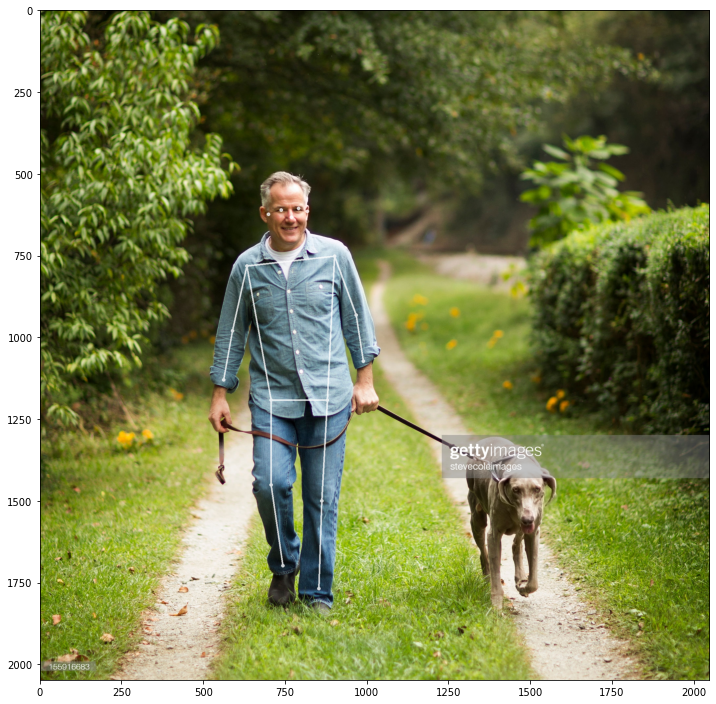

In [7]:
import time

# function to analyze person and keypoints in one image
def detect_on_image(image):
    
#     (im_width, im_height) = image.size
#     image = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)
    
    now_person = time.time()
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    then_person = time.time()
    
    # filter all objects but person (class 0)
#     print(detections['detection_classes'][0].numpy())
    person_indices = np.where(detections['detection_classes'][0].numpy()==0)[0]
#     print(person_indices)
    
    filtered_det_boxes = detections['detection_boxes'][0].numpy()[person_indices]
    filtered_det_classes = detections['detection_classes'][0].numpy()[person_indices]
    filtered_det_scores = detections['detection_scores'][0].numpy()[person_indices]

    # get only the most confident detection
    # ONLY DETECTING 1 PERSON!!
    height, width, channels = image.shape
#     print((height, width))
#     print(filtered_det_boxes[0])
    # ensemble bbox array with evopose order: [xmin, ymin, width, height]
    
    # if not person detected, then skip keypoint detection
    if filtered_det_boxes.size == 0:
        return image
    
    bbox_orig = np.multiply(filtered_det_boxes[0],[height, width,height, width])
    bbox_evo = [int(bbox_orig[1]),
                int(bbox_orig[0]), 
                int(bbox_orig[3]-bbox_orig[1]),
                int(bbox_orig[2]-bbox_orig[0])]
#     print(bbox_evo)
#     print(filtered_det_scores[0])

    # analize bbox with evopose2d
    now_evo = time.time()
    image_w_keypoints = evopose2d_predict(image, bbox_evo)
    then_evo = time.time()
#     print('Person detected at {:03.2f} fps, keypoints at {:03.2f} fps'.format(1/(then_person-now_person),1/(then_evo-now_evo)))
    
    label_id_offset = 1
    image_np_with_detections = image_w_keypoints

    # Use keypoints if available in detections
    keypoints, keypoint_scores = None, None
    if 'detection_keypoints' in detections:
      keypoints = detections['detection_keypoints'][0].numpy()
      keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

    # uncomment to draw bbox
#     viz_utils.visualize_boxes_and_labels_on_image_array(
#           image_np_with_detections,
#           filtered_det_boxes,
#           (filtered_det_classes + label_id_offset).astype(int),
#           filtered_det_scores,
#           category_index,
#           use_normalized_coordinates=True,
#           max_boxes_to_draw=200,
#           min_score_thresh=.30,
#           agnostic_mode=False,
#           keypoints=keypoints,
#           keypoint_scores=keypoint_scores,
#           keypoint_edges=get_keypoint_tuples(configs['eval_config']))

#     plt.figure(figsize=(12,16))
#     plt.imshow(image_np_with_detections)
#     plt.show()
    return image_np_with_detections
    
image = cv2.imread('/media/jose/Toshiba SSD1/Aictive/evopose2d/evopose2d/walking.jpg')

plt.figure(figsize=(12,16))
plt.imshow(detect_on_image(image))
plt.show()

## Video: Detect person -> Detect keypoints

30.00030000300003
480
640
Processing complete at average 6.33 fps erson pose at 7.05 fps


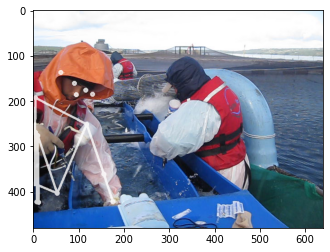

In [10]:
import time
# Loading an video
video_path = '/media/jose/Toshiba SSD1/Aictive/demos/Mutual/Muñeca Vacunador.AVI'
vidcap = cv2.VideoCapture(video_path)
fps = vidcap.get(cv2.CAP_PROP_FPS)
length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(fps)
print(frame_height)
print(frame_width)

outcap = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), int(30), (frame_width, frame_height))

count = 0
now_total = time.time()
while vidcap.isOpened():
    total_now = time.time()
    ret, image_bgr = vidcap.read()
    count += 1
    if count == 600:
        break

#     if rotate:    
#         # image_bgr = cv2.rotate(image_bgr, cv2.cv2.ROTATE_90_CLOCKWISE)
#         image_bgr = cv2.rotate(image_bgr, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)

    # image_bgr = cv2.flip(image_bgr, 1
    if not ret:
        break

    now = time.time()
    # Clone 1 image for debugging purpose
    image_debug = detect_on_image(image_bgr)
    then = time.time()
    image_debug = cv2.cvtColor(image_debug, cv2.COLOR_BGR2RGB)    

    
    print('Processing frame {} out of {}. Find person pose at {:03.2f} fps'.format(str(count),str(length),1/(then - now)),
          end='\r', flush=True)
    total_then = time.time()
    text = "{:03.2f} fps".format(1/(total_then - total_now))
    cv2.putText(image_debug, text, (100, 50), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)

    img_file = os.path.join('output_images', 'pose_{:08d}.jpg'.format(count))
    cv2.imwrite(img_file, image_debug)
    outcap.write(image_debug)
then_total = time.time()
vidcap.release()
outcap.release()
print("Processing complete at average {:03.2f} fps ".format(count/(then_total-now_total)))

